In [48]:
library(mlbench); library(ggplot2); library(GGally); library(reshape2) # melt fn

In [49]:
source('../src/load_data.r')

### Hunting for Outliers using Tukey's Method

#### Tukey's Method
Using Tukey's Method, outliers are defined as values < $Q_{1} - 1.5IQR$ and values > $Q_{3} + 1.5IQR$ where IQR is the *interquartile range*.  
$IQR = Q_{3} - Q{1}$  
where $Q_{1}$ is the value in the dataset >= 25% of the values and <=75% of the values in the datset, $Q_{2}$ is the value >= 50% of the values and <= the rest of the values, and so forth. 


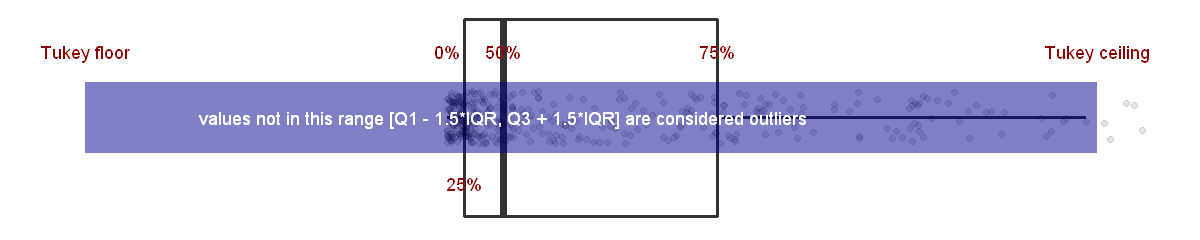

In [50]:
options(repr.plot.width = 10, repr.plot.height = 2)

q <- quantile(wholesale_data$Detergents_Paper)
iqr <- q['75%'] - q['25%']
q[['Tukey floor']] <- q['25%'] - 1.5*iqr
q[['Tukey ceiling']] <- q['75%'] + 1.5* iqr

horiz_boxplot <- ggplot(wholesale_data, aes(x = 0, y = Detergents_Paper)) + 
                    geom_boxplot(outlier.alpha = 0, size = 1) + 
                    coord_flip(ylim = c(-5500, 10000)) 

points <- geom_jitter(width = 0.1, alpha = 0.1)

labels <- annotate(geom = 'text', y = q, x = c(0.25, -0.25, 0.25, 0.25, -0.25, 0.25, 0.25),  
                  label = names(q), check_overlap = FALSE, color = 'darkred')

tukey_window <- annotate(geom = 'line', y = c(q['Tukey floor'], q['Tukey ceiling']), 
                         x = 0, size = 20, color = 'darkblue', alpha = 0.5) 
text_in_window <- annotate(geom = 'text', x = 0, y = q['50%'],
                           color = 'white',
                           label = 'values not in this range [Q1 - 1.5*IQR, Q3 + 1.5*IQR] are considered outliers')

blank_background <- theme(panel.background = element_blank(),
                          axis.line = element_blank(),
                          axis.ticks = element_blank(),
                          axis.text = element_blank(),
                          axis.title.x = element_blank(),
                          axis.title.y = element_blank()) 

tukey_graphic <- horiz_boxplot + points + labels + tukey_window + text_in_window + blank_background
print(tukey_graphic)

### Changing Size of 'Tukey Window'
Let's call the range of values not considered outliers under Tukey's method, Tukey's windows for simplicity. It's not a technical term. We will widen Tukey's window by changing the factor from 1.5 to 4 because this dataset contains many outliers. There is a large spread so it would be more useful to consider the values on the more extreme ends. 

In [51]:
# TODO: ADD display_outliers() to handy_fns or source
display_outliers <- function(feature, param = 4, df = wholesale_data) {
    feature_vec =  as.vector(wholesale_data[[feature]])
    Q1 <- quantile(feature_vec, .25)
    Q3 <- quantile(feature_vec, .75)
    tukey_window <- param*(Q3-Q1)

    # less_than_Q1 & greater_than_Q3 are masks, meaning they're vectors whose
    # elements are booleans
    less_than_Q1 <- wholesale_data[[feature]] < Q1 - tukey_window
    greater_than_Q3 <- wholesale_data[[feature]] > Q3 + tukey_window
    tukey_mask <- (less_than_Q1 | greater_than_Q3)
    outliers <- wholesale_data[tukey_mask,]
    return(outliers)
}


In [52]:
num_df <- Filter(is.numeric, wholesale_data)
outlier_dfs <- sapply(X = colnames(num_df), FUN = display_outliers, simplify = FALSE)

It is nice to be able to see the data frames filtered for outliers, but it's very granular. Let's get a count of the number of outliers for each feature. 

In [53]:
count_outliers <- function(feature) {
    outlier_count <- dim(display_outliers(feature))[1]
    return(outlier_count)
}

sapply(colnames(Filter(is.numeric, wholesale_data)), count_outliers)


Fresh             Milk          Grocery           Frozen 
               2                7                5               12 
Detergents_Paper             Deli 
               9                6

In [54]:
## sapply() is difficult because rownames() returns a vector and sapply does not append vectors to return a vector
## it will return a list which messes up following code

raw_outliers <- c()
for (feat in outlier_dfs) {
    ndx <- c(row.names(feat))
    raw_outliers <- c(raw_outliers, ndx)
}

freq_outliers <- as.data.frame(table(raw_outliers))

In [55]:
freq_outliers[freq_outliers$Freq > 1,]

raw_outliers Freq
2  126          2   
3  182          3   
4  184          3   
7  24           2   
12 334          2   
17 48           3   
19 62           3   
20 66           2   
22 86           3   
23 87           2

In [56]:
wholesale_data['outlier_for'] <- rownames(wholesale_data) %in% raw_outliers

In [57]:
outliers_many_feats <- freq_outliers[freq_outliers$Freq > 1,]$raw_outliers

In [58]:
many_feats <- rownames(wholesale_data) %in% outliers_many_feats
wholesale_data$outlier_for[many_feats] <- 'many_feats'

In [59]:
wholesale_data$outlier_for[wholesale_data$outlier_for == TRUE] <- 'one_feat'
wholesale_data$outlier_for[wholesale_data$outlier_for == FALSE] <- 'zero'

In [60]:
head(wholesale_data)

Channel Region Fresh Milk Grocery Frozen Detergents_Paper Deli outlier_for
1 Retail  Other  12669 9656 7561     214   2674             1338 zero       
2 Retail  Other   7057 9810 9568    1762   3293             1776 zero       
3 Retail  Other   6353 8808 7684    2405   3516             7844 one_feat   
4 Horeca  Other  13265 1196 4221    6404    507             1788 zero       
5 Retail  Other  22615 5410 7198    3915   1777             5185 zero       
6 Retail  Other   9413 8259 5126     666   1795             1451 zero

From R Documentation:

    ggpairs(data, mapping = NULL, columns = 1:ncol(data), title = NULL,
      upper = list(continuous = "cor", combo = "box_no_facet", discrete =
      "facetbar", na = "na"), lower = list(continuous = "points", combo =
      "facethist", discrete = "facetbar", na = "na"), diag = list(continuous =
      "densityDiag", discrete = "barDiag", na = "naDiag"), params = NULL, ...,
      xlab = NULL, ylab = NULL, axisLabels = c("show", "internal", "none"),
      columnLabels = colnames(data[columns]), labeller = "label_value",
      switch = NULL, showStrips = NULL, legend = NULL,
      cardinality_threshold = 15, legends = stop("deprecated"))


In [61]:
options(repr.plot.width = 10, repr.plot.height = 10)

pairplot_products <- function(data) {
    ggpairs(data = data, 
            columns = c('Fresh','Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Deli'), 
            mapping = aes(color = outlier_for),
            upper = list(continuous = wrap(ggally_cor, size = 2.5, alignPercent = 0.8)),
            lower = list(continuous = wrap(ggally_points, alpha = 0.2)),
           )    
}

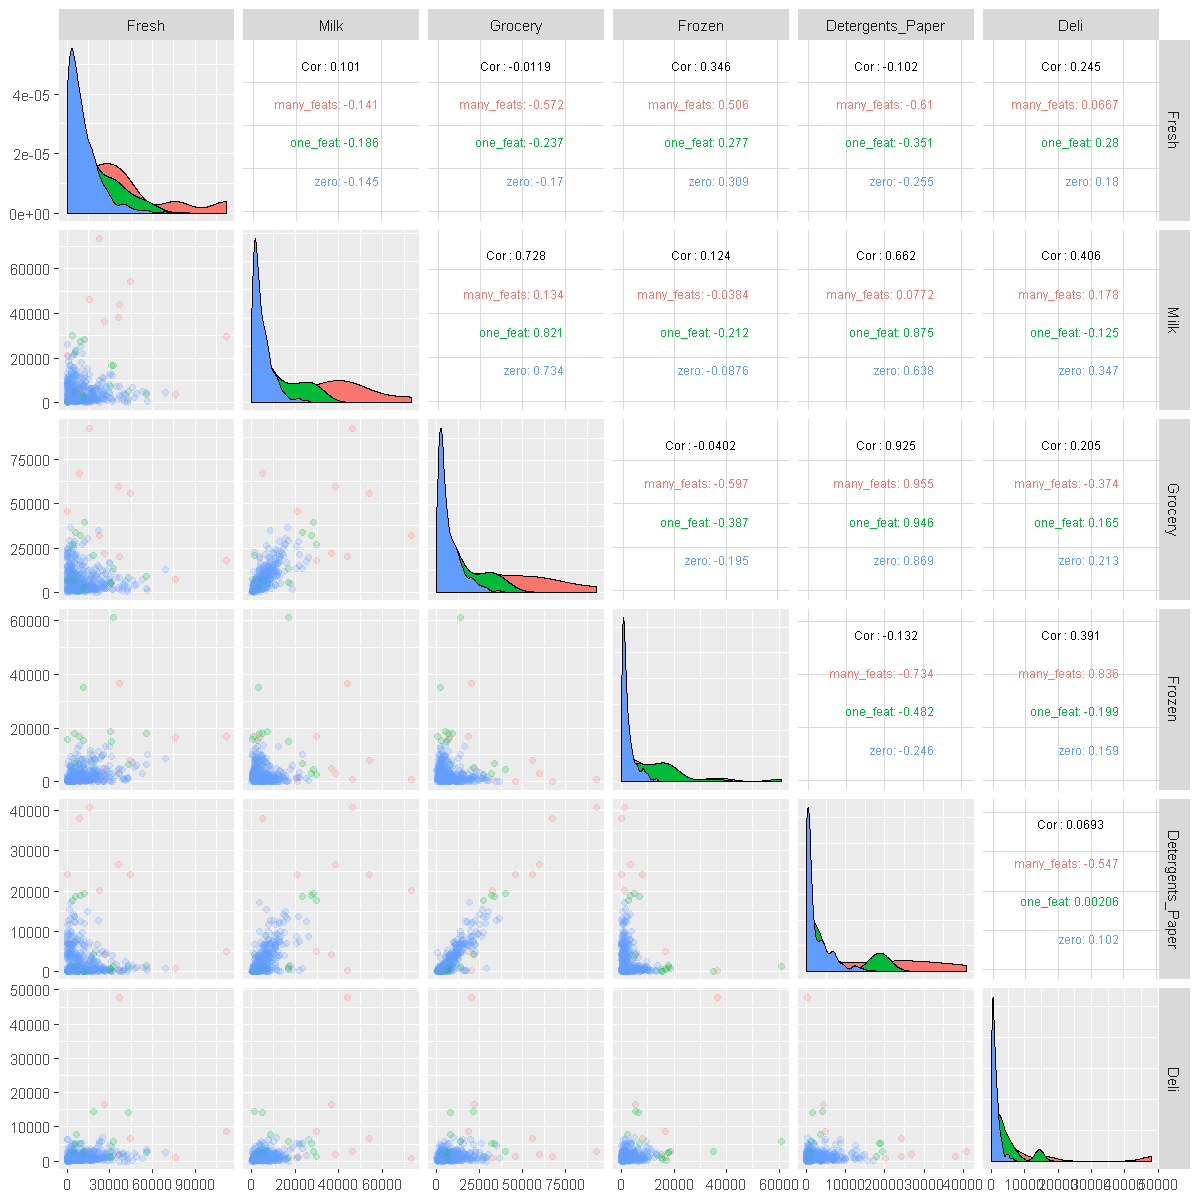

In [62]:
pairplot_products(wholesale_data)

Using Channel, Region, outlier_for as id variables


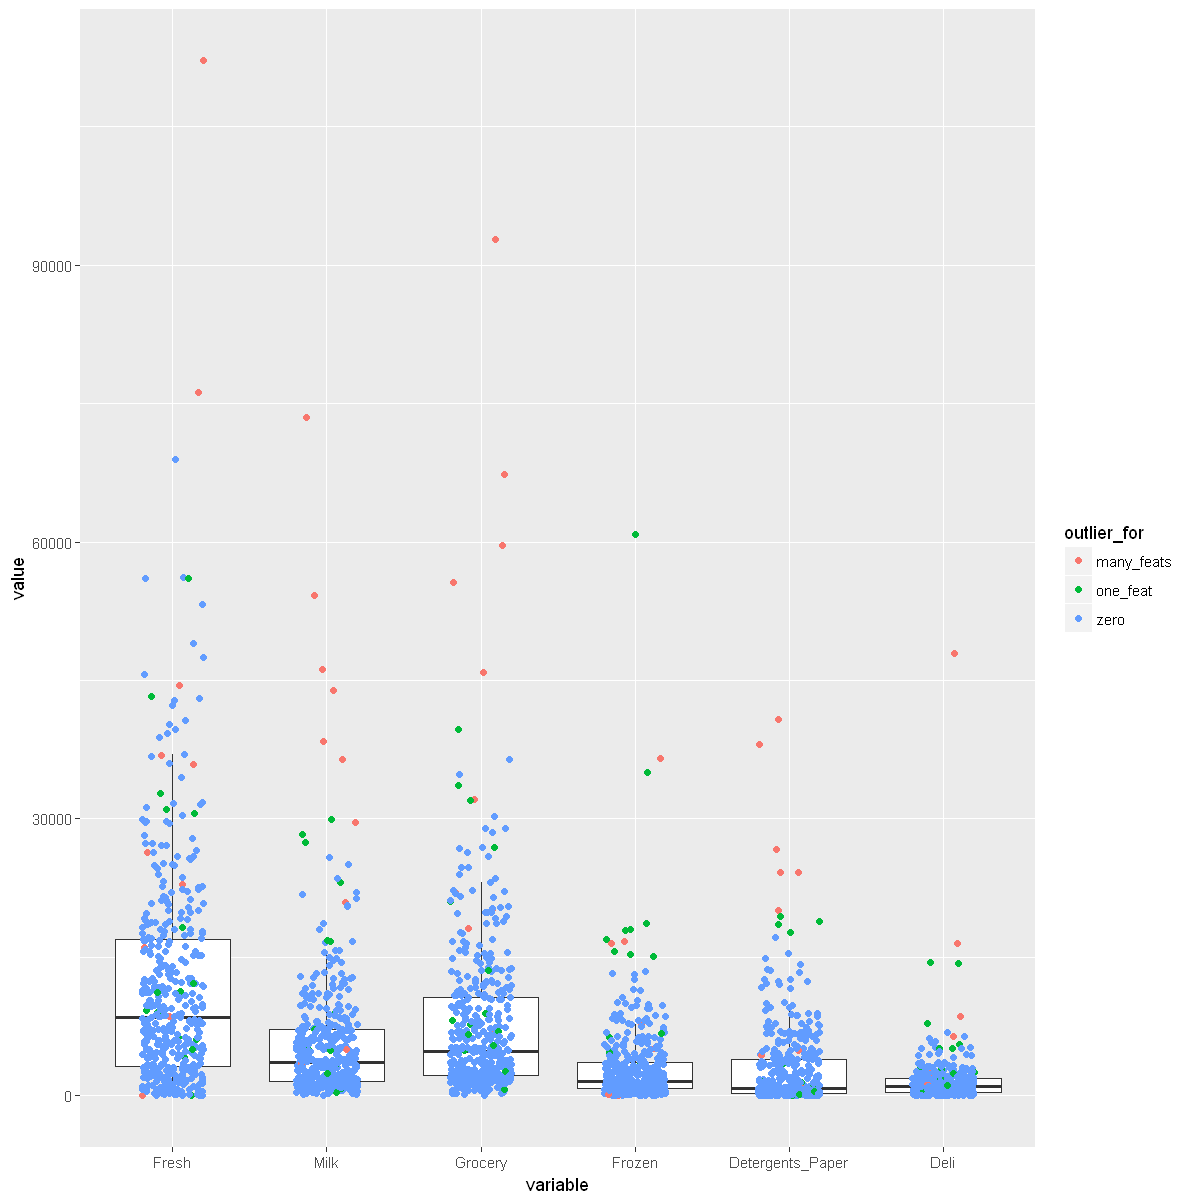

In [63]:
boxplot_product <- function(data) {
    ggplot(melt(data), aes(x = variable, y = value)) +
        geom_boxplot(outlier.alpha = 0) +
        geom_jitter(width = .2, aes(color = outlier_for))
}

boxplot_product(wholesale_data)

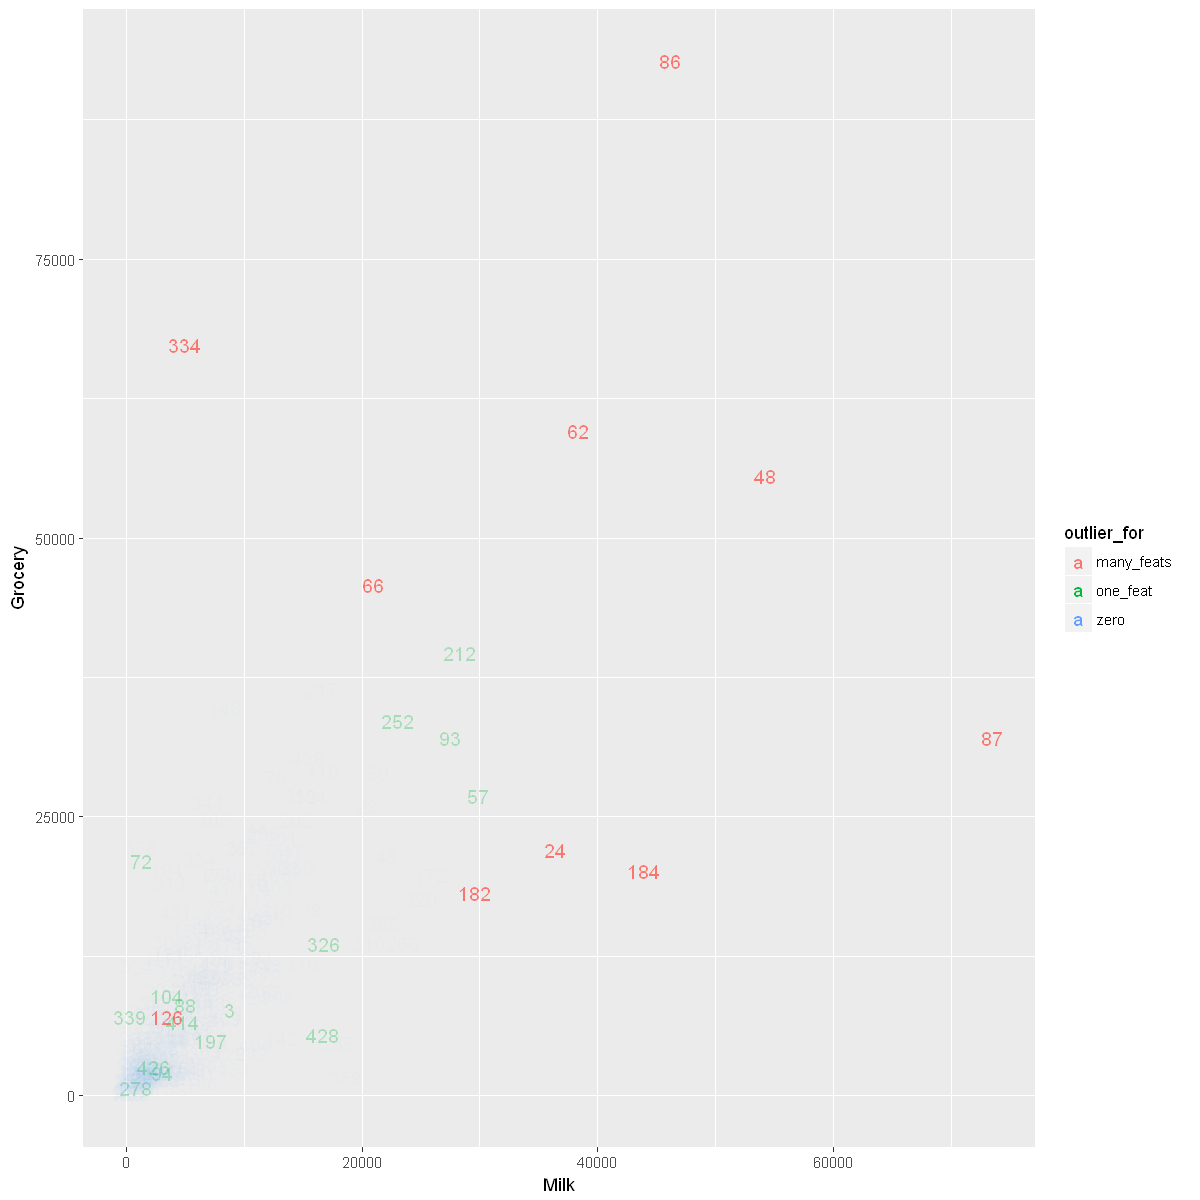

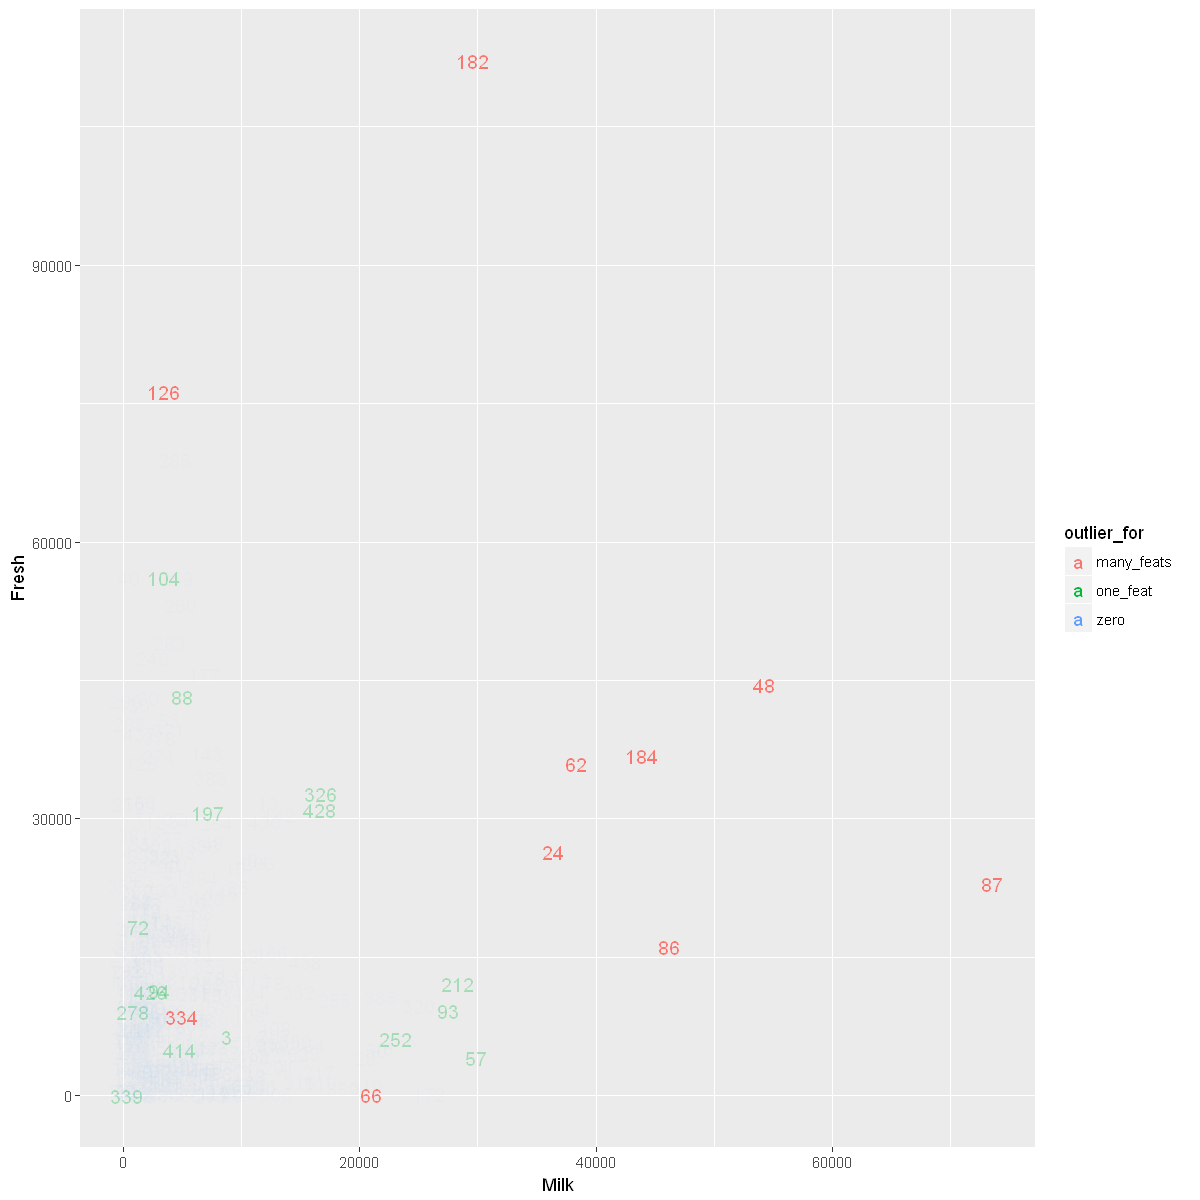

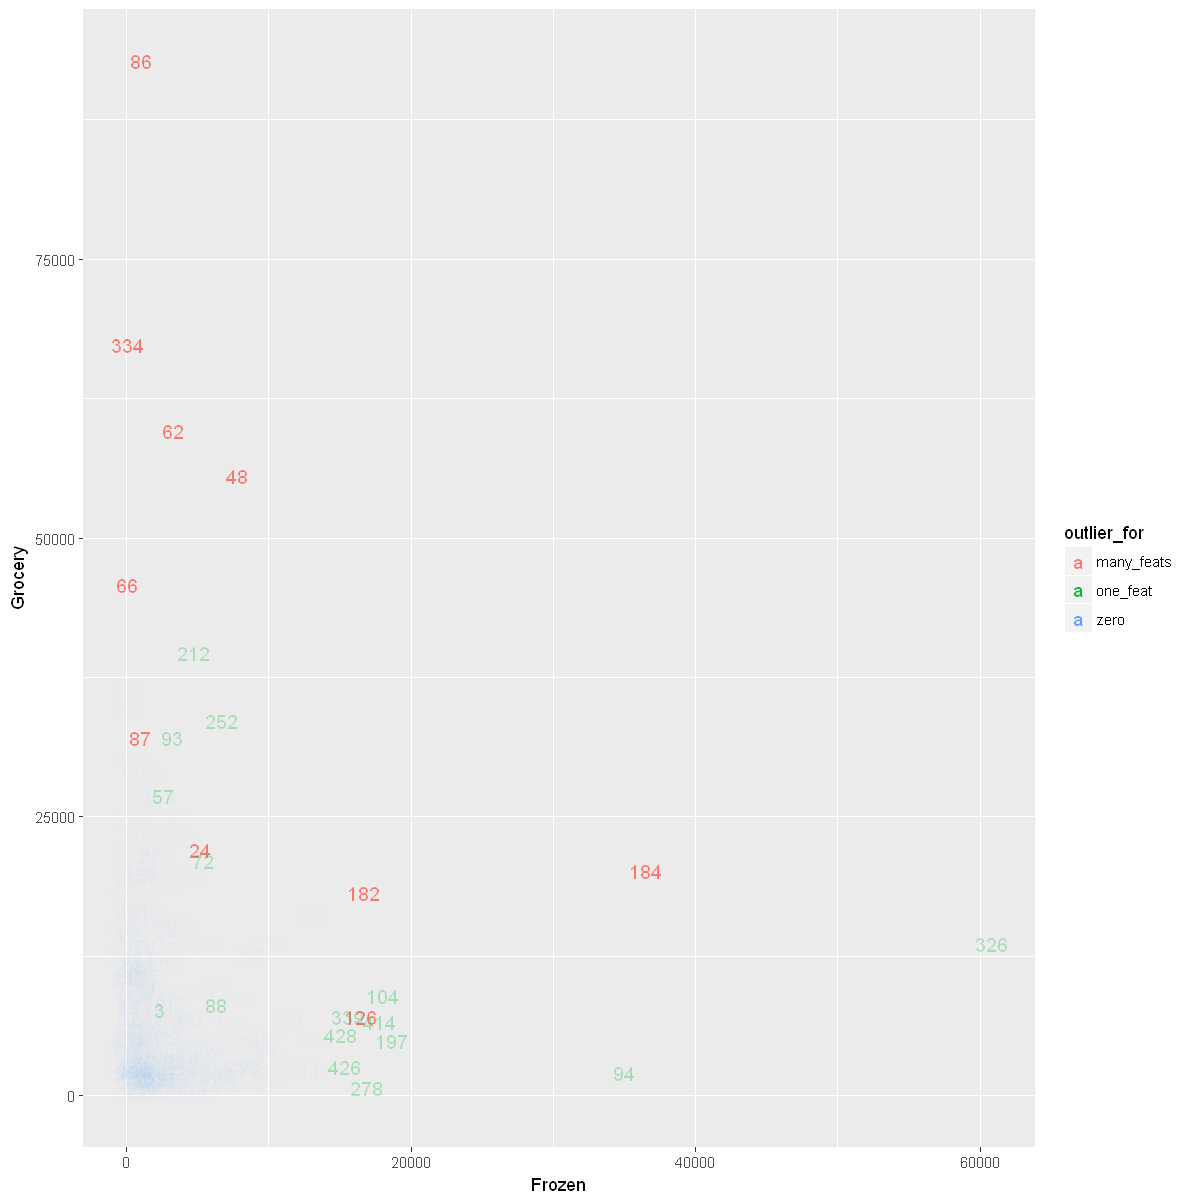

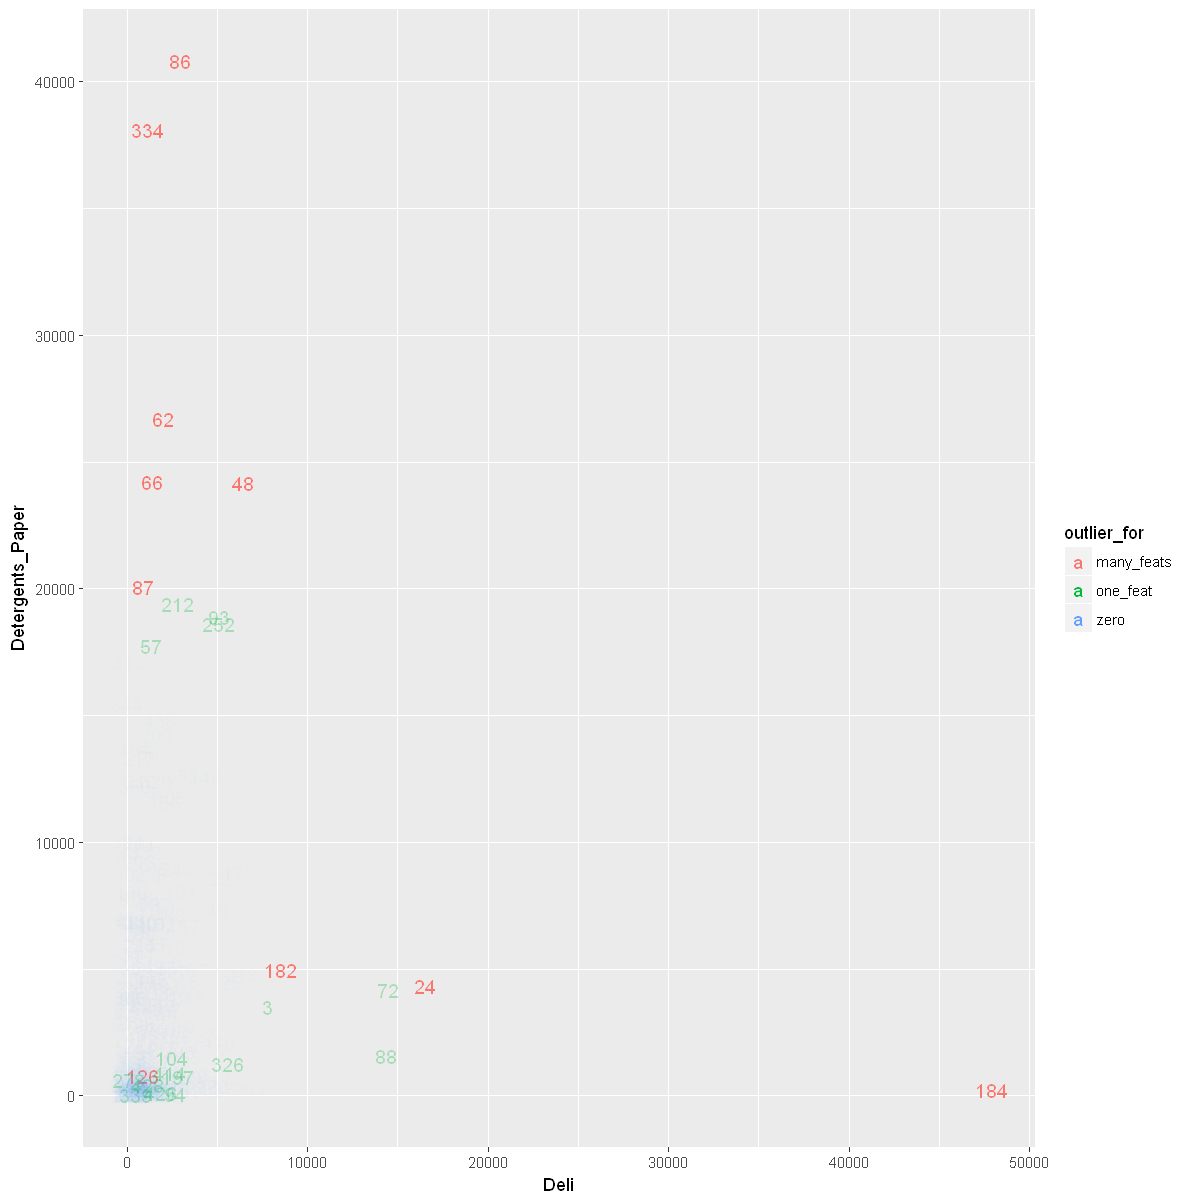

In [64]:
show_outliers_in_scatter <- function(xFeat, yFeat) {
    ggplot(wholesale_data, aes_string(x = substitute(xFeat), y = substitute(yFeat), color = 'outlier_for',
                                alpha = 'outlier_for')) +
    geom_text(check_overlap = FALSE, size = 4, aes(label = rownames(wholesale_data))) +
    scale_alpha_manual(guide = 'none', values = list(zero = 0.02, one_feat = 0.3, many_feats = 1))
}

show_outliers_in_scatter(Milk, Grocery)
show_outliers_in_scatter(Milk, Fresh)
show_outliers_in_scatter(Frozen, Grocery)
show_outliers_in_scatter(Deli, Detergents_Paper)

### Visualizing Data Without Outliers That Are Outliers for Multiple Features

Let's first see how many observations are outliers for multiple features.

In [65]:
dim(wholesale_data[wholesale_data$outlier_for != 'many_feats',])

[1] 430   9

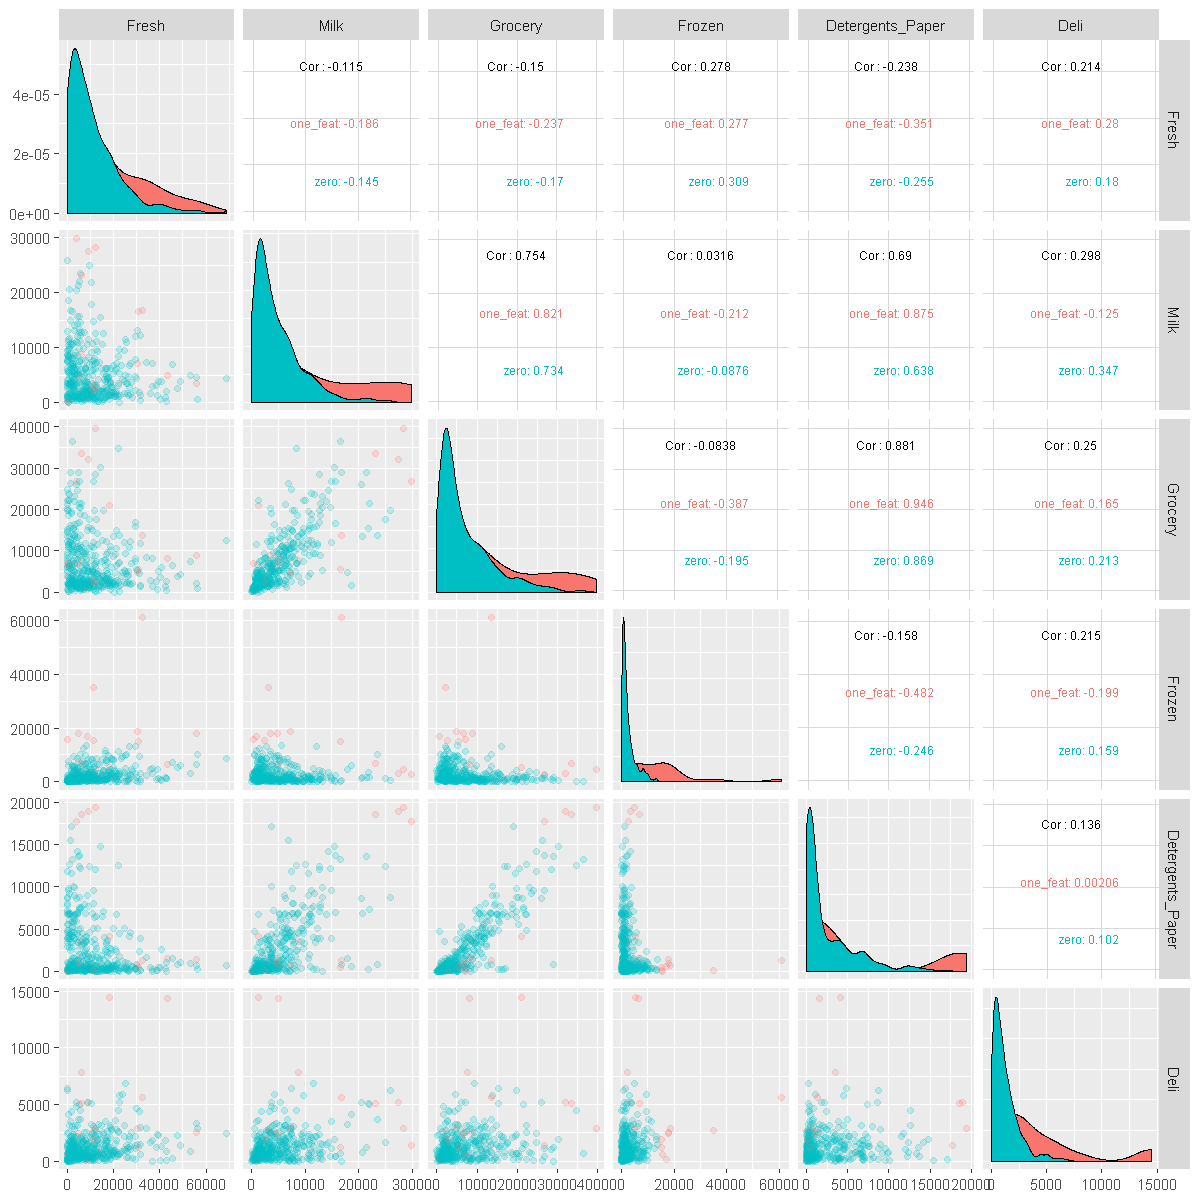

In [66]:
pairplot_products(wholesale_data[wholesale_data$outlier_for != 'many_feats',])

Using Channel, Region, outlier_for as id variables


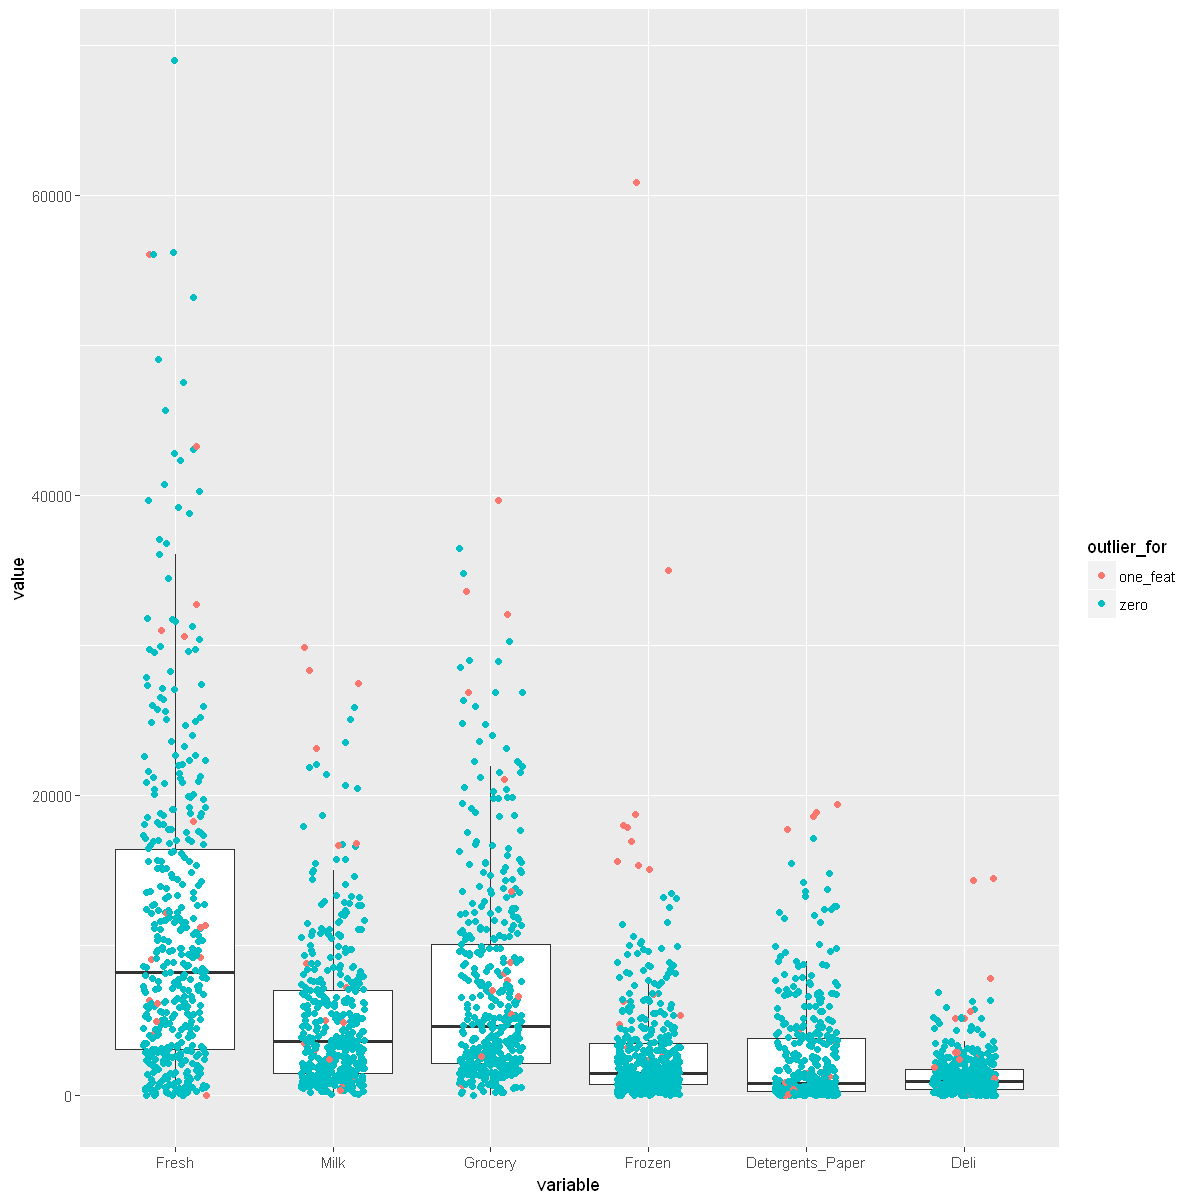

In [67]:
boxplot_product(wholesale_data[wholesale_data$outlier_for != 'many_feats',])

#### Verdict: Not Quite Removing Outliers
Usually, we would remove some outliers but there appears that outliers for many features are also the most extreme outliers within each feature. In practice, these outliers are significant because they represent customers that bring in a lot of business. We would be wise to not ignore them when analyzing our customers. 
However, while doing cluster modeling, these outliers will just add noise to our analysis of most of our customers. Thus, we will not consider these outliers that are outliers for many features in our clustering analysis. 

In [68]:
wholesale_data <- wholesale_data[wholesale_data$outlier_for != 'many_feats',]

In [69]:
clean_wholesale <- subset(wholesale_data, select = -c(outlier_for))
write.csv(clean_wholesale, file = '../data/clean_wholesale.csv')